### Wigner function

Wigner distribution function gives the phase space distribution of a function. <br>
The definition is as follows, as per Advances in Optics and Photonics 3, 272–365 (2011) : <br><br>

$W_{f}(p,q) = \left(\dfrac{|K|}{2\pi}\right)^{N}\int f^{*}\left(q-\dfrac{q^{'}}{2}\right) f\left(q+\dfrac{q^{'}}{2}\right)exp(-iKq^{'}.p)d^{N}q^{'}$<br><br>

### Implementation
This will be implemented in two steps. First the Ambiguity function will be calclualted.<br>
Now, the WDF is just the Fourier Transform of the AF (implemented via fft)                                                                                                                       

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scisig
from tqdm import tqdm
from numba import njit,prange

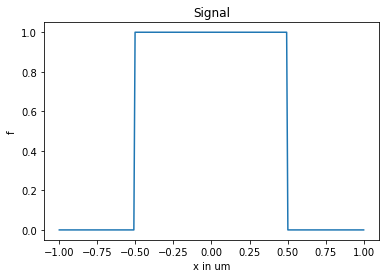

In [2]:
N = 250
f = np.zeros(N)
x = np.linspace(-1e-6,1e-6,N)
f[:] = 1
f[:int(N/4)]=0
f[int(3*N/4):]=0
plt.plot(x*1e6,f)
plt.ylabel('f')
plt.xlabel('x in um')
plt.title('Signal')
plt.show()

In [3]:
scale_factor = 3 #Scale domain by this much
# Assuming the domain is symmetrical, stretch on both sides
domain_real = np.linspace(scale_factor*x[0],scale_factor*x[-1],scale_factor*N) 

In [4]:
# Test function to verify positive and negative shifting of the original signal
# on a scaled domain
def f1(f,f_,y,domain):
    i = int((y-domain[0])/(domain[1]-domain[0]))
    f_[:] = 0
    N = len(f)
    f_[i-int(N/2):i+int(N/2)] = f
    return f_

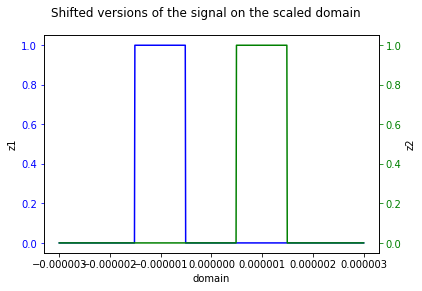

In [5]:
z1 = np.zeros(scale_factor*N)
z2 = np.zeros(scale_factor*N)
q1 = x[0]
q2 = x[-1]
z1 = f1(f,z1,q1,domain_real)
z2 = f1(f,z2,q2,domain_real)
fig,ax1 = plt.subplots(1,1)
ax1.plot(domain_real,z1,'b')
ax1.tick_params('y', colors='b')
ax1.set_ylabel('z1')
ax2 = ax1.twinx()
ax2.plot(domain_real,z2,'g')
ax2.tick_params('y', colors='g')
ax2.set_ylabel('z2')
ax1.set_xlabel('domain')
fig.suptitle('Shifted versions of the signal on the scaled domain')
plt.show()

In [6]:
# Computer the ambiguity function row by row.
@njit
def fill_AF(af,sig,domain,scale_factor,N):
    q1_vals = np.linspace(domain[0],domain[-1],scale_factor*N)
    for i in prange(scale_factor*N):
        q1 = q1_vals[i]
        z1 = np.zeros(scale_factor*N)
        z2 = np.zeros(scale_factor*N)
        i = int((q1/2-domain[0])/(domain[1]-domain[0]))
        z1[:] = 0
        z1[i-int(N/2):i+int(N/2)] = sig
    
        i = int((-q1/2-domain[0])/(domain[1]-domain[0]))
        z2[:] = 0
        z2[i-int(N/2):i+int(N/2)] = sig
        
        af[:,i] = z1*z2

In [7]:
AF = np.zeros((scale_factor*N,scale_factor*N))
fill_AF(AF,f,domain_real,scale_factor,N)
WDF = np.fft.fftshift(np.fft.fft(AF),axes=1)

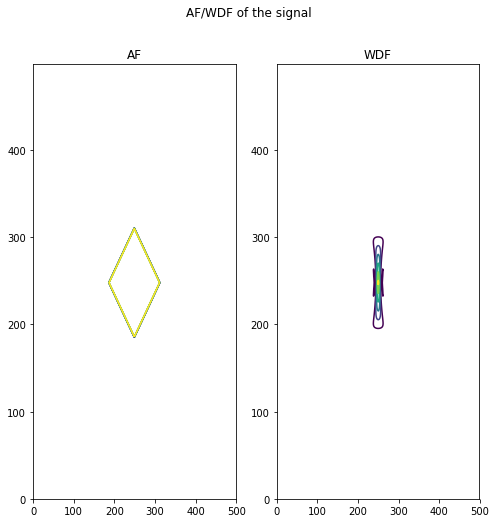

In [8]:
plt.rcParams["figure.figsize"] = (8,8)
N1 = int(scale_factor*N/2)
n1 = 250
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.contour(np.abs(AF)[N1-n1:N1+n1,N1-n1:N1+n1])
ax1.set_title('AF')
ax2.contour(np.abs(WDF)[N1-n1:N1+n1,N1-n1:N1+n1])
ax2.set_title('WDF')
fig.suptitle('AF/WDF of the signal')
plt.show()

In [9]:
# Calculate and scale the FT of the signal and the new frequency domain
F = np.abs(np.fft.fftshift(np.fft.fft(f)))
F = F/np.max(F)
x = np.fft.fftshift(np.fft.fftfreq(len(f)))
domain_freq = np.linspace(scale_factor*x[0],scale_factor*x[-1],scale_factor*N) 

In [10]:
AF = np.zeros((scale_factor*N,scale_factor*N))
fill_AF(AF,F,domain_freq,scale_factor,N)
WDF = np.fft.fftshift(np.fft.fft(AF),axes=1)

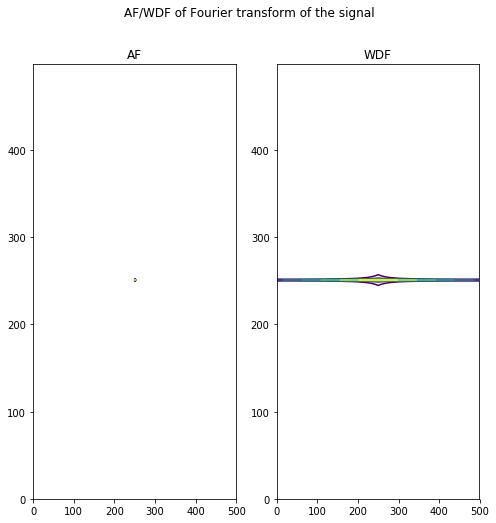

In [11]:
N1 = int(scale_factor*N/2)
n1 = 250
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.contour(np.abs(AF)[N1-n1:N1+n1,N1-n1:N1+n1])
ax1.set_title('AF')
ax2.contour(np.abs(WDF)[N1-n1:N1+n1,N1-n1:N1+n1])
ax2.set_title('WDF')
fig.suptitle('AF/WDF of Fourier transform of the signal')
plt.show()